# Transformer Models Customization Guide

RecTools provides many options to change any part of the model with custom modules: from training objective to special transformer layers logic. Current guide provides just a few examples of the various customizations that can be done.


### Table of Contents

* Prepare data
* "Next Action" training objective from Pinnerformer
    - Custom data preparator and lightning module
    - Create `NextActionTransformer`
    - Enable unidirectional attention
* ALBERT
    - Custom transformer layers and item net constructor
    - Pass ALBERT modules to `BERT4RecModel`
    - Pass ALBERT modules to `SASRecModel`
* How about `NextActionTransformer` with ALBERT modules and causal attention?
    - Combining custom modules together
* Cross-validation
* Configs support for custom models
* Full list of customization options

In [2]:
import os
import typing as tp
import typing_extensions as tpe
import warnings
from pathlib import Path

import torch.nn as nn
import pandas as pd
import torch
import numpy as np
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer

from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import BERT4RecModel, SASRecModel, PopularModel
from rectools.dataset.dataset import DatasetSchema
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models.nn.item_net import (
    ItemNetBase,
    SumOfEmbeddingsConstructor,
)
from rectools.models.nn.transformers.net_blocks import (
    PreLNTransformerLayer,
    TransformerLayersBase,
)
from rectools.models.nn.transformers.constants import MASKING_VALUE
from rectools.models.nn.transformers.bert4rec import BERT4RecDataPreparator
from rectools.models.nn.transformers.lightning import TransformerLightningModule
from rectools.visuals import MetricsApp

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
warnings.simplefilter("ignore")

## Prepare data

In [ ]:
# %%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O data_original.zip
!unzip -o data_original.zip
!rm data_original.zip

In [3]:
DATA_PATH = Path("data_en")

interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": "datetime"})
)
interactions[Columns.Weight] = 1
dataset = Dataset.construct(
    interactions_df=interactions,
)

In [4]:
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 60


60

In [5]:
# Function to get custom trainer

def get_debug_trainer() -> Trainer:
    return Trainer(
        accelerator="cpu",
        devices=1,
        min_epochs=1,
        max_epochs=1,
        deterministic=True,
        enable_model_summary=True,
        enable_progress_bar=False,
        limit_train_batches=2,  # limit train batches for quick debug runs
    )

## "Next Action" training objective from Pinnerformer
[PinnerFormer: Sequence Modeling for User Representation at Pinterest](https://arxiv.org/pdf/2205.04507)

This training objective aims to predict the most recent action for each user. Thus only one target should be taken from each user sequence.

We will take BERT4RecModel as our base class and just change one single detail in data preparation: let's put "MASK" token replacing the last position of each user sequence. Everything else will work out of the box.

For computational efficiency we will return `y` and `yw` (and `negatives`) in the shape of `(batch_size, 1)` instead of `(batch_size, session_max_len)`.
To process this reshaped batch correctly during training we will also rewrite training step in lightning module.

We could have filled `y` and `yw` with zeros except for the last target item. This way trainig step should have been left unchanged. But it's less efficient.

### Custom data preparator and lightning module

In [6]:
class NextActionDataPreparator(BERT4RecDataPreparator):
    
    def _collate_fn_train(
        self,
        batch: tp.List[tp.Tuple[tp.List[int], tp.List[float]]],
    ) -> tp.Dict[str, torch.Tensor]:
        """
        Truncate each session from right to keep `session_max_len` items.
        Do left padding until `session_max_len` is reached.
        Split to `x`, `y`, and `yw`.
        """
        batch_size = len(batch)
        x = np.zeros((batch_size, self.session_max_len))
        y = np.zeros((batch_size, 1))
        yw = np.zeros((batch_size, 1))
        for i, (ses, ses_weights) in enumerate(batch):
            session = ses.copy()
            session[-1] = self.extra_token_ids[MASKING_VALUE]  # Replace last token with "MASK"
            x[i, -len(ses) :] = session
            y[i] = ses[-1]
            yw[i] = ses_weights[-1]

        batch_dict = {"x": torch.LongTensor(x), "y": torch.LongTensor(y), "yw": torch.FloatTensor(yw)}
        if self.n_negatives is not None:
            negatives = torch.randint(
                low=self.n_item_extra_tokens,
                high=self.item_id_map.size,
                size=(batch_size, 1, self.n_negatives),
            )
            batch_dict["negatives"] = negatives
        return batch_dict


class NextActionLightningModule(TransformerLightningModule):

    def training_step(self, batch: tp.Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        """Training step."""
        x, y, w = batch["x"], batch["y"], batch["yw"]
        if self.loss == "softmax":
            logits = self._get_full_catalog_logits(x)[:, -1: :]  # take only token last hidden state
            loss = self._calc_softmax_loss(logits, y, w)
        elif self.loss == "BCE":
            negatives = batch["negatives"]
            logits = self._get_pos_neg_logits(x, y, negatives)[:, -1: :]  # take only last token hidden state
            loss = self._calc_bce_loss(logits, y, w)
        elif self.loss == "gBCE":
            negatives = batch["negatives"]
            logits = self._get_pos_neg_logits(x, y, negatives)[:, -1: :]  # take only last token hidden state
            loss = self._calc_gbce_loss(logits, y, w, negatives)
        else:
            loss = self._calc_custom_loss(batch, batch_idx)

        self.log(self.train_loss_name, loss, on_step=False, on_epoch=True, prog_bar=self.verbose > 0)

        return loss

### Create `NextActionTransformer`

In [7]:
next_action_model = BERT4RecModel(
    data_preparator_type=NextActionDataPreparator,
    lightning_module_type=NextActionLightningModule,
    get_trainer_func = get_debug_trainer,
)

next_action_model.fit(dataset)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 5.5 M  | train
-----------------------------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
22.040    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


### Enable unidirectional attention

In [8]:
next_action_model_causal = BERT4RecModel(
    data_preparator_type=NextActionDataPreparator,
    lightning_module_type=NextActionLightningModule,
    get_trainer_func = get_debug_trainer,
    use_causal_attn = True,  # simple flag
)
next_action_model.fit(dataset)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 5.5 M  | train
-----------------------------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
22.040    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


## ALBERT
[ALBERT: A Lite BERT for Self-supervised Learning of Language Representations](https://arxiv.org/abs/1909.11942)

ALBERT has two parameter-reduction techniques to lower memory consumption and increase the training speed which can actually be used together or separately:
1. Learning embeddings of smaller size and then projecting them to the required size through a Liner projection ("Factorized embedding parameterization")
2. Sharing weights between transformer layers ("Cross-layer parameter sharing")

We will implement both techiques in custom classes for transformer layers and for item net constructor.

### Custom item net constructor and transformer layers

In [9]:
# Special ALBERT logic for embeddings - Factorized embedding parameterization

class AlbertSumConstructor(SumOfEmbeddingsConstructor):

    def __init__(
        self,
        n_items: int,
        n_factors: int,
        item_net_blocks: tp.Sequence[ItemNetBase],
        emb_factors: int = 16,  # accept new kwarg for lower dimensional space size
    ) -> None:
        super().__init__(
            n_items=n_items,
            item_net_blocks=item_net_blocks,
        )
        self.item_emb_proj = nn.Linear(emb_factors, n_factors)  # Project to actual required hidden space

    @classmethod
    def from_dataset(
        cls,
        dataset: Dataset,
        n_factors: int,
        dropout_rate: float,
        item_net_block_types: tp.Sequence[tp.Type[ItemNetBase]],
        emb_factors: int,  # accept new kwarg for lower dimensional space size
    ) -> tpe.Self:
        n_items = dataset.item_id_map.size

        item_net_blocks: tp.List[ItemNetBase] = []
        for item_net in item_net_block_types:
            # Item net blocks will work in lower dimensional space
            item_net_block = item_net.from_dataset(dataset, emb_factors, dropout_rate)
            if item_net_block is not None:
                item_net_blocks.append(item_net_block)

        return cls(n_items, n_factors, item_net_blocks, emb_factors)

    @classmethod
    def from_dataset_schema(
        cls,
        dataset_schema: DatasetSchema,
        n_factors: int,
        dropout_rate: float,
        item_net_block_types: tp.Sequence[tp.Type[ItemNetBase]],
        emb_factors: int,  # accept new kwarg for lower dimensional space size
    ) -> tpe.Self:
        n_items = dataset_schema.items.n_hot

        item_net_blocks: tp.List[ItemNetBase] = []
        for item_net in item_net_block_types:
            item_net_block = item_net.from_dataset_schema(dataset_schema, emb_factors, dropout_rate)
            if item_net_block is not None:
                item_net_blocks.append(item_net_block)

        return cls(n_items, n_factors, item_net_blocks, emb_factors)

    def forward(self, items: torch.Tensor) -> torch.Tensor:
        item_embs = super().forward(items)  # Create embeddings in lower dimensional space
        item_embs = self.item_emb_proj(item_embs)  # Project to actual required hidden space
        return item_embs

In [10]:
# Special ALBERT logic for transformer layers - Cross-layer parameter sharing
    
class AlbertLayers(TransformerLayersBase):

    def __init__(
        self,
        n_blocks: int,
        n_factors: int,
        n_heads: int,
        dropout_rate: float,
        ff_factors_multiplier: int = 4,
        n_hidden_groups: int=1,  # accept new kwarg
        n_inner_groups: int=1,  # accept new kwarg
        
    ):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.n_hidden_groups = n_hidden_groups
        self.n_inner_groups = n_inner_groups
        n_fitted_blocks = int(n_hidden_groups * n_inner_groups)
        self.transformer_blocks = nn.ModuleList(
            [
                PreLNTransformerLayer(
                    # number of encoder layer (AlBERTLayers)
                    # https://github.com/huggingface/transformers/blob/main/src/transformers/models/albert/modeling_albert.py#L428
                    n_factors,
                    n_heads,
                    dropout_rate,
                    ff_factors_multiplier,
                )
                # https://github.com/huggingface/transformers/blob/main/src/transformers/models/albert/modeling_albert.py#L469
                for _ in range(n_fitted_blocks)
            ]
        )
        self.n_layers_per_group = n_blocks / n_hidden_groups

    def forward(
        self,
        seqs: torch.Tensor,
        timeline_mask: torch.Tensor,
        attn_mask: tp.Optional[torch.Tensor],
        key_padding_mask: tp.Optional[torch.Tensor],
    ) -> torch.Tensor:
        for block_idx in range(self.n_blocks):
            group_idx = int(block_idx / self.n_layers_per_group)
            for inner_layer_idx in range(self.n_inner_groups):
                layer_idx = group_idx * self.n_inner_groups + inner_layer_idx
                seqs = self.transformer_blocks[block_idx](seqs, attn_mask, key_padding_mask)
        return seqs


### Pass ALBERT modules to `BERT4RecModel`
Now we need to pass both our custom classes and their keyword arguments for initialization.

In [11]:
CONSTRUCTOR_KWARGS = {
    "emb_factors": 64,
}

TRANSFORMER_LAYERS_KWARGS = {
    "n_hidden_groups": 2,
    "n_inner_groups": 2,
}

albert_model = BERT4RecModel(
    item_net_constructor_type=AlbertSumConstructor,      # type
    item_net_constructor_kwargs=CONSTRUCTOR_KWARGS,      # kwargs
    transformer_layers_type=AlbertLayers,                # type
    transformer_layers_kwargs=TRANSFORMER_LAYERS_KWARGS, # kwargs
    get_trainer_func = get_debug_trainer,
)

albert_model.fit(dataset)
# See that with Albert modules we have 4.2 M trainable params instead of 5.5 M previously

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 4.2 M  | train
-----------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.710    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


### Pass ALBERT modules to `SASRecModel`
We are not limited to BERT4Rec when we just changed embedding and transformer layers logic.
Why not create ALSASRec?

In [12]:
alsasrec_model = SASRecModel(
    item_net_constructor_type=AlbertSumConstructor,
    item_net_constructor_kwargs=CONSTRUCTOR_KWARGS,
    transformer_layers_type=AlbertLayers,
    transformer_layers_kwargs=TRANSFORMER_LAYERS_KWARGS,
    get_trainer_func = get_debug_trainer,
)
alsasrec_model.fit(dataset)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 4.2 M  | train
-----------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.711    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


## How about `NextActionTransformer` with ALBERT modules and causal attention?
Just because we can!
### Combining custom modules together

In [13]:
next_action_albert_causal = BERT4RecModel(
    item_net_constructor_type=AlbertSumConstructor,
    item_net_constructor_kwargs=CONSTRUCTOR_KWARGS,
    transformer_layers_type=AlbertLayers,
    transformer_layers_kwargs=TRANSFORMER_LAYERS_KWARGS,
    data_preparator_type=NextActionDataPreparator,
    lightning_module_type=NextActionLightningModule,
    use_causal_attn=True,
    get_trainer_func = get_debug_trainer,
)
next_action_albert_causal.fit(dataset)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 4.2 M  | train
-----------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.710    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


## Cross-validation
Let's validate our custom models compared to vanilla SASRec

In [14]:
# Initialize models for cross-validation

def get_trainer() -> Trainer:
    return Trainer(
        accelerator="gpu",
        devices=[1],
        min_epochs=3,
        max_epochs=3,
        deterministic=True,
        enable_model_summary=False,
        enable_progress_bar=False,
    )

next_action_bidirectional = BERT4RecModel(
    data_preparator_type=NextActionDataPreparator,
    lightning_module_type=NextActionLightningModule,
    deterministic=True,
    get_trainer_func=get_trainer,
)

next_action_unidirectional = BERT4RecModel(
    data_preparator_type=NextActionDataPreparator,
    lightning_module_type=NextActionLightningModule,
    deterministic=True,
    use_causal_attn=True,
    get_trainer_func=get_trainer,
)

CONSTRUCTOR_KWARGS = {
    "emb_factors": 64,
}
TRANSFORMER_LAYERS_KWARGS = {
    "n_hidden_groups": 2,
    "n_inner_groups": 2,
}

albert = BERT4RecModel(
    item_net_constructor_type=AlbertSumConstructor,
    item_net_constructor_kwargs=CONSTRUCTOR_KWARGS,
    transformer_layers_type=AlbertLayers,
    transformer_layers_kwargs=TRANSFORMER_LAYERS_KWARGS,
    deterministic=True,
    get_trainer_func=get_trainer,
)

alsasrec = SASRecModel(
    item_net_constructor_type=AlbertSumConstructor,
    item_net_constructor_kwargs=CONSTRUCTOR_KWARGS,
    transformer_layers_type=AlbertLayers,
    transformer_layers_kwargs=TRANSFORMER_LAYERS_KWARGS,
    deterministic=True,
    get_trainer_func=get_trainer,
)

sasrec_albert_layers = SASRecModel(
    transformer_layers_type=AlbertLayers,
    transformer_layers_kwargs=TRANSFORMER_LAYERS_KWARGS,
    deterministic=True,
    get_trainer_func=get_trainer,
)


models = {
    "popular": PopularModel(),
    "sasrec":  SASRecModel(deterministic=True),
    "next_action_bidirectional": next_action_bidirectional,
    "next_action_unidirectional": next_action_unidirectional,
    "albert": albert,
    "alsasrec": alsasrec,
    "sasrec_albert_layers": sasrec_albert_layers,
}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
# Validate models

metrics = {
    "HitRate@10": HitRate(k=10),
    "MAP@10": MAP(k=10),
    "Serendipity@10": Serendipity(k=10),
    "CoveredUsers@10": CoveredUsers(k=10),  # how many test users received recommendations
    "AvgRecPopularity@10": AvgRecPopularity(k=10),  # average popularity of recommended items
    "Intersection@10": Intersection(k=10),  # intersection with recommendations from reference model
}

splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=1,  # 1 fold
    filter_already_seen=True,
)

K_RECS = 10

# For each fold generate train and test part of dataset
# Then fit every model, generate recommendations and calculate metrics

cv_results = cross_validate(
    dataset=dataset,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
    ref_models=["popular"],  # pass reference model to calculate recommendations intersection
    validate_ref_models=True,
)

pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)
pivot_results.to_csv("rectools_custom_transformers_cv_en.csv", index=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_epochs=3` reached.


In [16]:
pivot_results

,HitRate@10,MAP@10,AvgRecPopularity@10,Serendipity@10,Intersection@10_popular,CoveredUsers@10
model,,,,,,
popular,0.274365,0.080114,82236.761783,0.000002,1.000000,1.0
sasrec,0.316917,0.092236,70526.243531,0.000029,0.621130,1.0
next_action_bidirectional,0.347769,0.099488,57260.700878,0.000099,0.461527,1.0
next_action_unidirectional,0.342954,0.100581,54372.509136,0.000107,0.445071,1.0
albert,0.332552,0.095702,62428.868590,0.000050,0.514052,1.0
alsasrec,0.346951,0.098554,50137.404580,0.000199,0.393441,1.0
sasrec_albert_layers,0.347487,0.100079,50387.782216,0.000250,0.424036,1.0


In [ ]:
models_metrics = pivot_results.reset_index()[["model", "MAP@10", "Serendipity@10"]]

app = MetricsApp.construct(
    models_metrics=models_metrics,
    scatter_kwargs={
        "symbol_sequence": ['circle', 'square', 'diamond', 'cross', 'x', 'star', 'pentagon'],
    }
)
fig = app.fig
fig.update_layout(title="Model CV metrics", font={"size": 15})
fig.update_traces(marker={'size': 9})
fig.show("png")

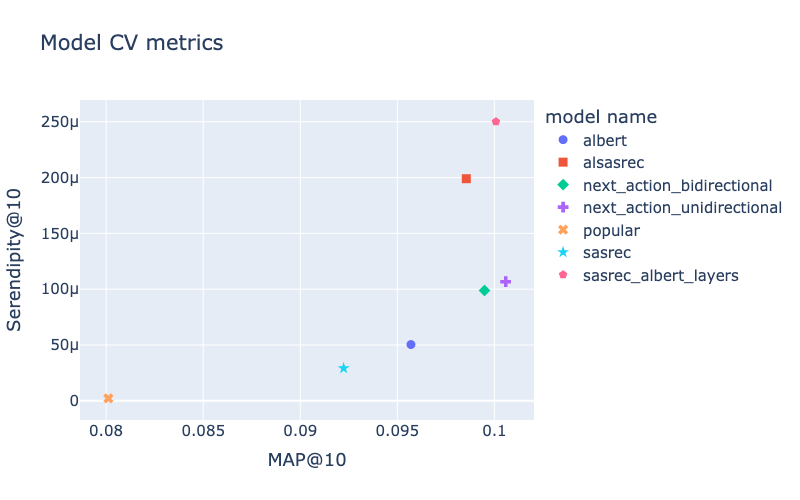

## Configs support for custom models
All custom models fully support initialization from configs and other RecTools benefits. For models with keyword arguments we suggest to use `from_params` method that accepts configs in a flat dict form. See example below:

**Important: only JSON serializable custom keyword argument values are accepted during customization**

In [19]:
params = next_action_albert_causal.get_params(simple_types=True)
params
# See below that model params include our custom keyword arguments:
# "transformer_layers_kwargs.n_hidden_groups", 
# "transformer_layers_kwargs.n_inner_groups"
# and "item_net_constructor_kwargs.emb_factors"

{'cls': 'BERT4RecModel',
 'verbose': 0,
 'data_preparator_type': '__main__.NextActionDataPreparator',
 'n_blocks': 2,
 'n_heads': 4,
 'n_factors': 256,
 'use_pos_emb': True,
 'use_causal_attn': True,
 'use_key_padding_mask': True,
 'dropout_rate': 0.2,
 'session_max_len': 100,
 'dataloader_num_workers': 0,
 'batch_size': 128,
 'loss': 'softmax',
 'n_negatives': 1,
 'gbce_t': 0.2,
 'lr': 0.001,
 'epochs': 3,
 'deterministic': False,
 'recommend_batch_size': 256,
 'recommend_device': None,
 'recommend_n_threads': 0,
 'recommend_use_torch_ranking': True,
 'train_min_user_interactions': 2,
 'item_net_block_types': ['rectools.models.nn.item_net.IdEmbeddingsItemNet',
  'rectools.models.nn.item_net.CatFeaturesItemNet'],
 'item_net_constructor_type': '__main__.AlbertSumConstructor',
 'pos_encoding_type': 'rectools.models.nn.transformers.net_blocks.LearnableInversePositionalEncoding',
 'transformer_layers_type': '__main__.AlbertLayers',
 'lightning_module_type': '__main__.NextActionLightningMod

In [20]:
model = BERT4RecModel.from_params(params)
model.fit(dataset)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 4.2 M  | train
-----------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.710    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


## Full list of customization options

These blocks of RecTools transformer models can be replaced with custom classes (WITH an option to add required keyword arguments for initialization):
- data preparator (`data_preparator_type`, `data_preparator_kwargs`)
    - forming training objectives
    - providing train, val and recommend dataloaders preparation
- lightning module (`lightning_module_type`, `lightning_module_kwargs`)
    - tying of user session latent represenation and candidate embeddings
    - training, validation and recommending logic
    - losses computation
    - weights initialization
    - optimizer configuration
- item net constructor (`item_net_constructor_type`, `item_net_constructor_kwargs`)
    - way for aggregating outputs from item net blocks
- transformer layers (`transformer_layers_type`, `transformer_layers_kwargs`)
- positional encoding (`pos_encoding_type`, `pos_encoding_kwargs`)

These blocks of RecTools transformer models can be replaced with custom classes (WITHOUT an option to add keyword arguments):
- item net blocks (`item_net_block_types`)

These keyword model arguments have great effect on model architecture:
- `use_causal_attn` (applies unidirectional attention instead of bidirectional when set to ``True``)